## Digit Recognizer Mnist
I guess this is the most standard and basic computer vision use case and data set. So i have to have it in the portfolio. 
The data is from http://yann.lecun.com/exdb/mnist/

train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)


In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#unzipping
import gzip
import shutil
import os
all_files = os.listdir("data")
data_paths = [x for x in all_files if x.endswith(".gz")]
for path in data_paths:
    out_path = path[:-3]
    if out_path in all_files:
        continue  # unzip only if not there
    with gzip.open(f"data/{path}", 'rb') as f_in:
        with open(f"data/{out_path}", 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [3]:
# dont want to spend too much time to write the parser when others have done it.
# Its not the goal of this notebook to learn it.
# credit to Marc Garcia 
# https://github.com/datapythonista/mnist/blob/master/mnist/__init__.py
import struct
import numpy as np
import array
import functools
import operator

class IdxDecodeError(ValueError):
    """Raised when an invalid idx file is parsed."""
    pass

def parse_idx(fd):
    """Parse an IDX file, and return it as a numpy array.
    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse
    endian : str
        Byte order of the IDX file. See [1] for available options
    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file
    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))
    # ok so this is doing most of the work
    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian
    
    # dimensions (1,2,3) -> 1*2*3 = 6
    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))

    return np.array(data).reshape(dimension_sizes)

In [4]:
def read_mnist_data(path:str) -> np.array:
    with open(f"data/{path}", "rb") as file:
        return parse_idx(file)

X_train=read_mnist_data('train-images-idx3-ubyte')
y_train=read_mnist_data('train-labels-idx1-ubyte')
X_test=read_mnist_data('t10k-images-idx3-ubyte')
y_test=read_mnist_data('t10k-labels-idx1-ubyte')

Of course we want to use Deep Learning / Neural networks but lets for a second assume it didnt exist. What would be an easy model we could use as a baseline. I think K-nearest neighbours is a good baseline.

## Baseline Model: Nearest Neighbour

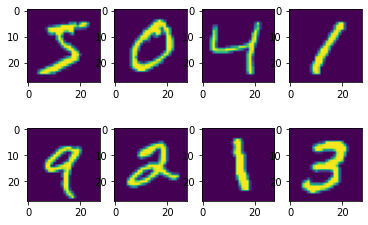

In [5]:
from matplotlib import pyplot as plt
fig,axs = plt.subplots(2,4)
for i in range(8):
    axs[i//4, i%4].imshow(X_train[i])
plt.show()
#smooth , easy to plot <3

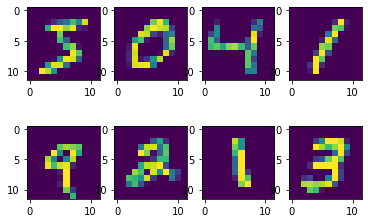

In [6]:
# Some of the models are slow and i dont like waiting, so we scale down the images ...
# !pip install opencv-python
import cv2
X_train_small = np.array([cv2.resize(X_train[i,:], (12,12)) for i in range(X_train.shape[0])])
X_test_small = np.array([cv2.resize(X_test[i,:], (12,12)) for i in range(X_test.shape[0])])
fig,axs = plt.subplots(2,4)
for i in range(8):
    axs[i//4, i%4].imshow(X_train_small[i])
plt.show()
# oh wow looks terrible, but ok. 

In [7]:
# !pip install -U scikit-learn~=1.0.2
from sklearn.neighbors import KNeighborsClassifier
# we flatten the image from matrix to a vector so that we can just throw it into nearest
# neighbors. We dont take into account at all which pixels are next to each other. Sounds bad.
def flatten(X_train):
    return np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_train_flat = flatten(X_train_small)
X_test_flat = flatten(X_test_small)

#test the reshape, maybe i have a typo or mixed something up.
nrow = X_train_small.shape[1]
ncol = X_train_small.shape[2]
assert X_train_flat.shape == (X_train_small.shape[0],nrow*ncol)
for sample in range(X_train.shape[0]):
    for row in range(nrow):
        for col in range(ncol):
            assert X_train_flat[sample][ncol*row+col] == X_train_small[sample,row,col]


In [8]:
nbrs = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree').fit(X_train_flat, y_train)

In [9]:
%%time 
#30
train_pred = nbrs.predict(X_train_flat[:1000,:])

CPU times: user 13.2 s, sys: 42.4 ms, total: 13.3 s
Wall time: 13.3 s


In [10]:
# decent training fit
sum(train_pred == y_train[:1000])/1000

0.979

In [11]:
%%time
test_pred = nbrs.predict(X_test_flat)

CPU times: user 2min 14s, sys: 610 ms, total: 2min 14s
Wall time: 2min 15s


In [12]:
# pretty good actually
sum(test_pred == y_test)/len(test_pred)

0.9583

# Neural Networks

In [13]:
#!pip install -U tensorflow~=2.3.0
import tensorflow as tf


ok lets try a simple and random neural network. Since convolutional layers were basically invented to work on pictures, we just take a bunch of conv layers with random parameters and see if that beats the baseline.

### Preprocessing

In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder().fit(y_train.reshape(-1, 1))
y_one_hot = encoder.transform(y_train.reshape(-1, 1)).toarray()
# should be the same encoding!
y_one_hot_test = encoder.transform(y_test.reshape(-1,1)).toarray()

X_train_4d=np.expand_dims(X_train,axis=3)
X_test_4d=np.expand_dims(X_test,axis=3)

# since we have different lighting in real world than mnist data set we try this preprocessing:
# this is also scaling which helps quick convergence since the starting weights are 
# probably closer to the optimal values.
X_train_4d[X_train_4d<150] =0 
X_train_4d[X_train_4d>=150] =1

X_test_4d[X_test_4d<150] =0 
X_test_4d[X_test_4d>=150] =1


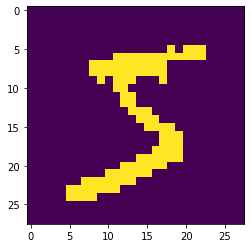

In [15]:
plt.imshow(X_train_4d[0,:,:,0])

In [16]:
assert set(X_train_4d.flatten().tolist()) == {0,1}
assert set(X_test_4d.flatten().tolist()) == {0,1}


In [17]:
# one hot encoding the multi class y is usually a standard approach.
# [1, 5, 8, 2]
# -> [0,1,0,0,0,0,0,0,0,0]
#    [0,0,0,0,0,1,0,0,0,0]
#    [0,0,0,0,0,0,0,0,1,0]
#    [0,0,1,0,0,0,0,0,0,0]

# for a binary classification problem use as a last activation function the sigmoid so that the result is always a 
# probability between 0 and 1
# for several classes we can scale the output of all the classes such that the sum of
# the probabilities is 1
# for this use softmax



In [18]:
# if we also rescale to smaller images its faster
# first i increased the number of filters and layers until it could overfit the train set.
# then adding some dropout to generalize better
# last dense layer still pretty large, probably better to reduce number of nodes,
# with for example pooling layers.
# The pooling layer improved the quality on the real world handwriting test data 

In [19]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import Sequential
# building chaining
pic_size=28
inputs = tf.keras.Input(shape=(pic_size,pic_size,1))
layer1 = Conv2D(filters=20, kernel_size=7, activation="relu")(inputs)
layer1_drop = Dropout(rate=0.1)(layer1)
layer2 = Conv2D(filters=10, kernel_size=4, activation="relu")(layer1_drop)
layer2_drop = Dropout(rate=0.1)(layer2)
layer3 = Conv2D(filters=10, kernel_size=4, activation="relu")(layer2_drop)
layer3_drop = Dropout(rate=0.1)(layer3)
flat = Flatten()(layer3_drop)
outputs = Dense(units=10, activation='softmax')(flat)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# building with Sequential
def build_nn_model(pooling=True):
    model = Sequential()
    model.add(Conv2D(20, kernel_size=7,
                     activation='relu',
                     input_shape=(pic_size,pic_size,1)))
    model.add(Dropout(rate=0.1))
    model.add(Conv2D(10, kernel_size=4,
                     activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Conv2D(10, kernel_size=4,
                     activation='relu'))
    model.add(Dropout(rate=0.1))
    if pooling:
        model.add(MaxPooling2D((4,4)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model
model=build_nn_model()


In [21]:
%load_ext tensorboard
# sick jupyter notebook feature
%tensorboard --logdir logs
# looking at the test error

Reusing TensorBoard on port 6006 (pid 76725), started 0:45:46 ago. (Use '!kill 76725' to kill it.)

In [22]:
logdir = os.path.join("logs", pd.Timestamp.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model=build_nn_model(True)
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy())
model.summary()
model.fit(X_train_4d, y_one_hot, epochs=10, callbacks=[tensorboard_callback],
          validation_data=(X_test_4d, y_one_hot_test))
#looks like its still improving but its ok

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 22, 22, 20)        1000      
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 10)        3210      
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 19, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 10)        1610      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 10)         

In [23]:
model_no_pool=build_nn_model(False)
model_no_pool.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy())
model_no_pool.summary()
model_no_pool.fit(X_train_4d, y_one_hot, epochs=10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 22, 22, 20)        1000      
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 20)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 19, 19, 10)        3210      
_________________________________________________________________
dropout_10 (Dropout)         (None, 19, 19, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 10)        1610      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2560)             

In [24]:
# softmax prediction results in the sum of all classes being 1
pred_one_hot=model.predict(X_train_4d[[0],:,:])
assert np.allclose(sum(pred_one_hot[0,:]), 1)

In [25]:
def eval_model(model, X_train_4d, y_train):
    pred_one_hot=model.predict(X_train_4d)
    pred = encoder.inverse_transform(pred_one_hot)
    return sum(pred.flatten() == y_train)/y_train.shape
eval_model(model, X_train_4d, y_train)

array([0.98605])

In [26]:
# both similar and couple percent better than the knn baseline, ofcourse a lot of room to tune.
print(eval_model(model, X_test_4d, y_test))
print(eval_model(model_no_pool, X_test_4d, y_test))

[0.9863]
[0.9882]


# Test 1: Prediction stability to moving the number by one pixel

In [27]:
pool_err=[]
no_pool_err =[]
for pixelsx, pixelsy in [(1,0),(-1,0),(0,1),(0,-1), (2,0),(-2,0),(0,2),(0,-2), (3,0),(-3,0),(0,3),(0,-3)]:
    print(pixelsx,pixelsy)
    X_right = X_test_4d.copy()
    M = np.float32([
        [1, 0, pixelsx],
        [0, 1, pixelsy]
    ])
    X_shift = np.expand_dims(np.array([cv2.warpAffine(X_right[i,:,:,:], M, (28,28)) for i in range(X_right.shape[0])]), 3)
    pool_err.append(eval_model(model, X_shift, y_test)[0])
    no_pool_err.append(eval_model(model_no_pool, X_shift, y_test)[0])
    

1 0
-1 0
0 1
0 -1
2 0
-2 0
0 2
0 -2
3 0
-3 0
0 3
0 -3


In [28]:
# Since maxpool is taking the max value over some part of the picture i would expect it to result in the 
# same result if some pattern is shifted in the image. So i would expect better quality of it when shifting the image.
print(np.mean(pool_err))
np.mean(no_pool_err)

# 1.2% better, so maybe its true?, not 100% sure could also be that the random parameters i have are better for 
# the pool layer. Both quite stable to the shift though.
# probably there are some good ways to make a network stable to translation but lets not dive into this right now

0.925675


0.9130666666666666

# Test 2: which class is the hardest to predict? does it make sense?

In [29]:
# what is the easieast number?
# my guess would be 0,8 easy 1 and 7 look the same so hard, 5 and 9 can be similar, 2 is pretty unique so easy
# 0,8,2,4,3,5,9,7,1 ?
pred_one_hot=model.predict(X_test_4d)
pred = encoder.inverse_transform(pred_one_hot)
k=0

print(f"accuracy {k} {sum([p == y for p,y in zip(pred,y_test) if y == k])/sum(y_test == k)}")

accuracy 0 [0.99591837]


In [30]:
l=[]
for k in range(10):
    acc = sum([p == y for p,y in zip(pred,y_test) if y == k])/sum(y_test == k)
    l.append((acc,k))
    print(f"accuracy {k} {acc}")

accuracy 0 [0.99591837]
accuracy 1 [0.99647577]
accuracy 2 [0.98062016]
accuracy 3 [0.98514851]
accuracy 4 [0.99592668]
accuracy 5 [0.98206278]
accuracy 6 [0.98538622]
accuracy 7 [0.97276265]
accuracy 8 [0.99691992]
accuracy 9 [0.97125867]


In [31]:
l.sort(reverse=True)
l
print([x[1] for x in l])
print([0,8,2,4,3,5,9,7,1])
# i thought since the seven looks like a 1 it might also get the 1 wrong but i guess it just 
# guesses 1 if in doubt so the accuracy is good there. forgot the 6 ... lel

[8, 1, 4, 0, 6, 3, 5, 2, 7, 9]
[0, 8, 2, 4, 3, 5, 9, 7, 1]


In [32]:
l=[]
for k in range(10):
    acc = sum([p == y for p,y in zip(pred,y_test) if p == k])/sum(pred == k)
    l.append((acc,k))
    print(f"accuracy {k} {acc}")
l.sort(reverse=True)
print(l)

accuracy 0 [0.98585859]
accuracy 1 [0.98262381]
accuracy 2 [0.99215686]
accuracy 3 [0.99301397]
accuracy 4 [0.98489426]
accuracy 5 [0.99319728]
accuracy 6 [0.99578059]
accuracy 7 [0.99206349]
accuracy 8 [0.95476893]
accuracy 9 [0.9908999]
[(array([0.99578059]), 6), (array([0.99319728]), 5), (array([0.99301397]), 3), (array([0.99215686]), 2), (array([0.99206349]), 7), (array([0.9908999]), 9), (array([0.98585859]), 0), (array([0.98489426]), 4), (array([0.98262381]), 1), (array([0.95476893]), 8)]


In [33]:
mat = [[0]*10 for _ in range(10)]
for k1 in range(10):
    for k2 in range(10):
        if k1==k2:
            continue # only show the wrong ones
        pred_k1_k2 = [p == k1 for p,y in zip(pred,y_test) if y == k2]
        acc = sum(pred_k1_k2)/len(pred_k1_k2)
        mat[k1][k2] = acc[0] 

<AxesSubplot:>

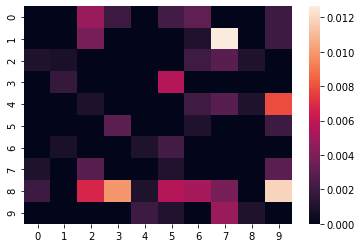

In [34]:
import seaborn as sns
sns.heatmap(mat)
# 1 and 7  are similar and 8 and 9

In [35]:
# of course i overfitted slightly on the test set by playing around with the parameters.
# I dont believe any of the results anyway until I see them with my own eyes. So lets do a research vs reality.

In [36]:
# I have written some digits. Lets see if the model can handle it

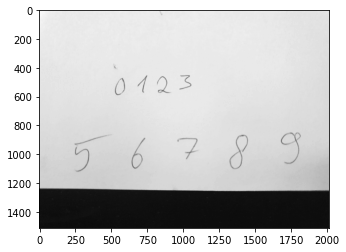

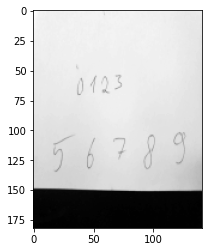

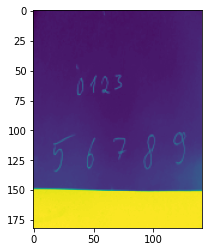

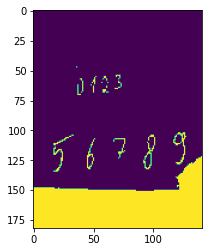

In [37]:
import cv2
kernel_size=28
def read_image_and_preprocess(path, scalex, scaley, rotate=False):
    img = cv2.imread(path, 0)
    if rotate:
        img=cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(img, cmap='gray')
    plt.show()

    img = cv2.resize(img, (img.shape[0]*28//scalex,img.shape[1]*28//scaley), interpolation=cv2.INTER_AREA)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    # we have the opposite dark on writing and bright in background so lets try and invert
    img = cv2.bitwise_not(img)
    plt.imshow(img)
    plt.show()
    # round the brightness
    img[img<118] =0 
    img[img>=118] =1
    plt.imshow(img)
    plt.show()
    assert len(set(img[:,:].flatten().tolist())) == 2
    
    #throw away some pixels on the sides so that its easy to program the filtering
    kernel_size = 28
    rows = img.shape[0] - img.shape[0]%kernel_size
    cols = img.shape[1] - img.shape[1]%kernel_size
    img = img[:rows, :cols]
    assert img.shape[0]% 28 ==0 
    assert img.shape[1]% 28 ==0 
    return img
img=read_image_and_preprocess('data/handwriting1.jpeg', 300,310)

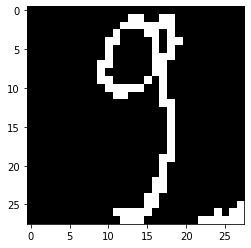

In [38]:
row=101
col=108
part_of_image = img[row:row+kernel_size, col:col+kernel_size]
plt.imshow(part_of_image, cmap='gray')

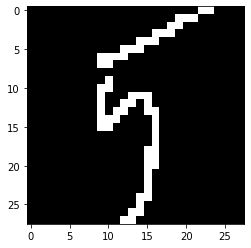

[0.   0.   0.   0.   0.01 0.3  0.   0.   0.   0.68]
it is a 9


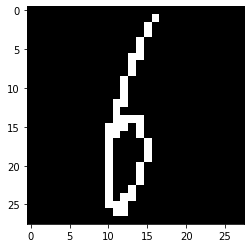

[0.   0.   0.   0.   0.01 0.01 0.62 0.   0.36 0.  ]
it is a 6


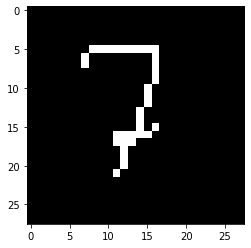

[0.   0.01 0.59 0.13 0.   0.   0.   0.21 0.06 0.  ]
it is a 2


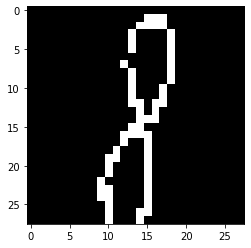

[0.   0.   0.   0.   0.01 0.   0.   0.   0.99 0.  ]
it is a 8


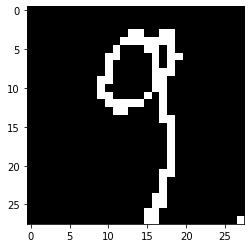

[0.   0.   0.   0.   0.86 0.   0.   0.   0.   0.14]
it is a 4


In [39]:
def test_handwriting(img, positions):
    for row,col in positions:
        part_of_image = np.expand_dims(img[row:row+kernel_size, col:col+kernel_size],axis=2)
        if part_of_image.shape != (28,28,1):
            continue
        res = model.predict(np.expand_dims(part_of_image,axis=0))
        plt.imshow(part_of_image, cmap='gray')
        plt.show()

        if max(res[0]) > 0.3:
            print(np.round(res,2)[0])
            print(f"it is a {np.argmax(res[0])}")
test_handwriting(img, [(105, 8), (106,35), (102, 60), (103, 83), (99, 108)])

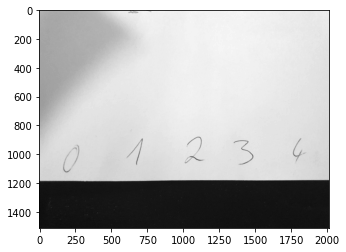

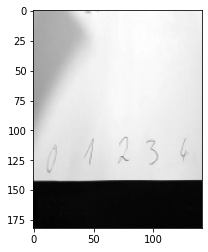

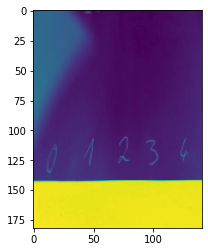

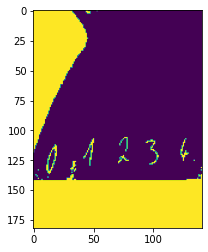

In [40]:
img2=read_image_and_preprocess('data/handwriting2.jpeg', 300,310)

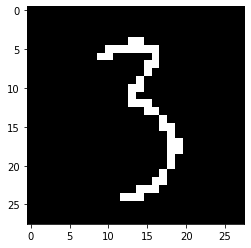

In [41]:
row=104
col=85
part_of_image = img2[row:row+kernel_size, col:col+kernel_size]
plt.imshow(part_of_image, cmap='gray')

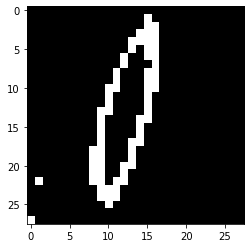

[0.81 0.02 0.01 0.   0.01 0.   0.02 0.   0.14 0.  ]
it is a 0


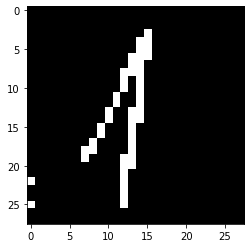

[0.   0.98 0.   0.   0.02 0.   0.   0.   0.   0.  ]
it is a 1


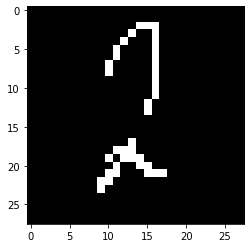

[0.   0.05 0.93 0.01 0.   0.   0.   0.   0.01 0.  ]
it is a 2


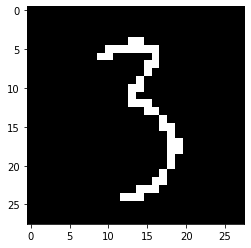

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
it is a 3


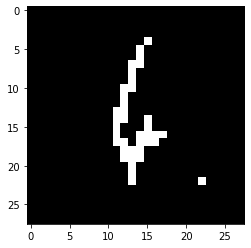

[0.   0.   0.   0.   0.76 0.   0.22 0.   0.01 0.01]
it is a 4


In [42]:
test_handwriting(img2, [(111, 3), (104,35), (104, 62), (104,85), (103, 112)])

In [43]:
# nice it gets a solid 7 out of 10 :D, better than expected to be honest
# but could be better i guess.

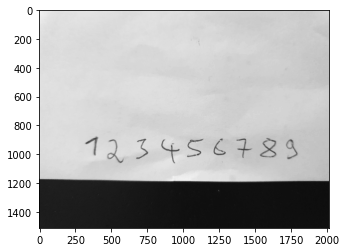

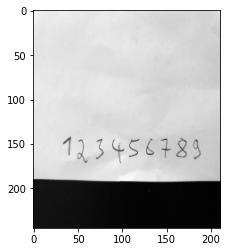

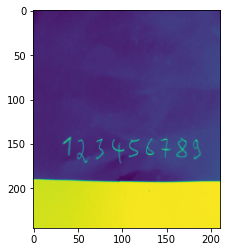

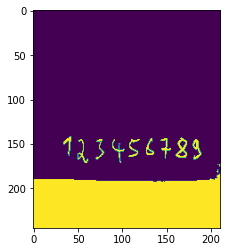

In [44]:
img3=read_image_and_preprocess('data/handwriting.jpeg', 200,230, rotate=True)
# I forgot the 0 because im a mathematician

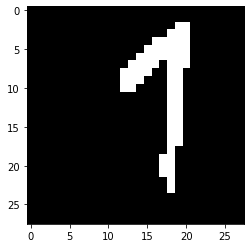

[0.   0.01 0.01 0.   0.08 0.   0.   0.9  0.   0.  ]
it is a 7


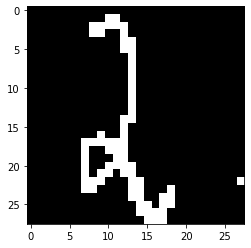

[0.   0.93 0.05 0.   0.   0.   0.   0.   0.02 0.  ]
it is a 1


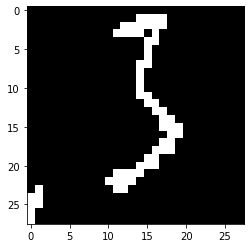

[0.   0.   0.   0.96 0.   0.03 0.   0.   0.   0.  ]
it is a 3


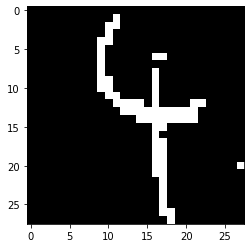

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
it is a 4


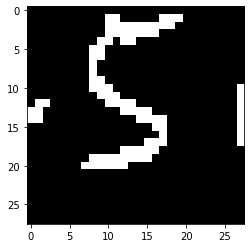

[0.   0.   0.   0.   0.02 0.97 0.   0.   0.01 0.  ]
it is a 5


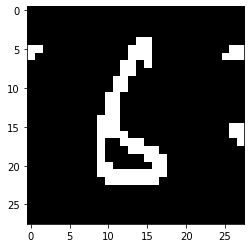

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
it is a 6


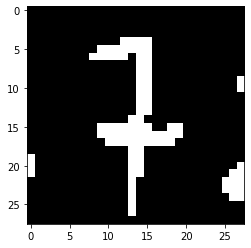

[0.   0.   0.   0.   0.01 0.   0.   0.99 0.   0.  ]
it is a 7


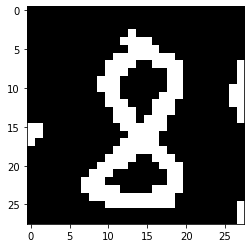

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
it is a 8


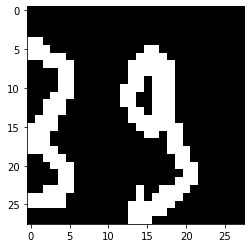

[0.   0.   0.   0.02 0.78 0.   0.   0.   0.18 0.02]
it is a 4


In [45]:
# i wrote the numbers slightly to close to each other. Deal with it.
test_handwriting(img3, [(140, 22), (144, 43), (144, 60), (144, 80), (144, 100),
                        (140, 118), (140, 135), (140, 153), (140, 167)])
# 6 out of 9

I can see a million ways how this will fail in real life if we just deploy this in an app.
Good preprocessing is probably key.

I want to reproduce shap explainable AI plots. I read that there was this paper saying that you can just overfit on one
pixel the whole mnist dataset to high accuracy. It looks decent on my handwritten digits so maybe not complete fraud.
But could be that it does not understand the shape really but maybe just counts average brightness in parts of the image.


## Understanding the model with shap. Explainable AI

In [46]:
# !pip install shap
import shap
#https://github.com/slundberg/shap

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


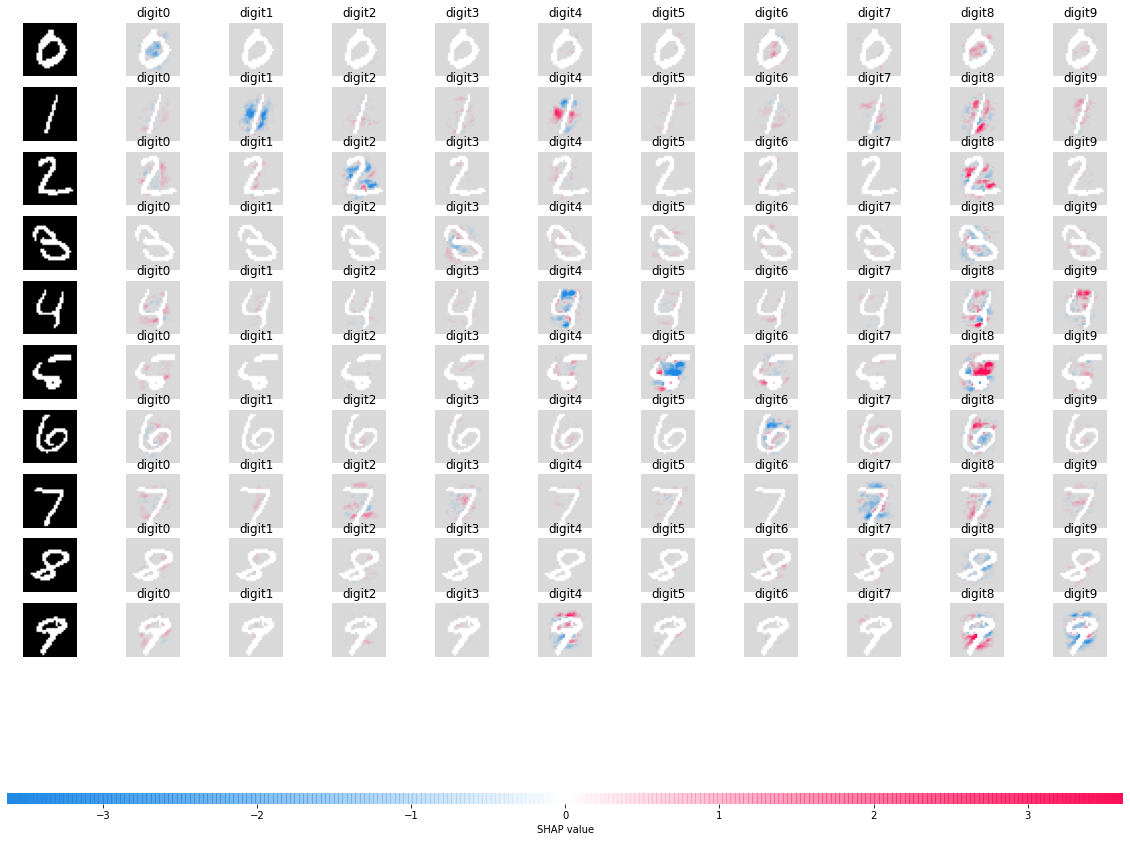

In [47]:
e = shap.GradientExplainer(model, X_train_4d)
test_data_for_shap = X_test_4d[[3,2,1,18,4,8,11,0,61,9]]
shap_values = e.shap_values(test_data_for_shap, output_rank_order="custom")
# plot the explanations
shap.image_plot(shap_values, test_data_for_shap, [[f"digit{i}" for i in range(10)] for _ in range(test_data_for_shap.shape[0])])

its beautiful <3

Interpretation: If you look for example at row of digit 3 and then look at columns 3 and 8.
If there were pixels closing the open parts of the 3 then it would become less of a 3 which is denoted by
blue pixels in column digit 3 and would become more of an 8 which is denoted by red pixels in column digit 8.

Similar the 4 would become a 9 if the top was closed. (red pixels at the top of the 4 for the digit9 column)

We can play around more but i think i saw what i wanted to do. Convolutional Neural Networks 
are really good for image use cases. It can actually recognize digits on real fotos in okayish quality and i would only continue to tune if i want to build some real application with it.

If you look inside a little then its less of a blackbox and shap is a useful package!